In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

In [2]:
# n = 200
# p = 2000
# p_causal = 50
# pve = 0.95
# rho = 0.0
# k = 20

# X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 100)
# X      = center_and_scale(X)
# Xtest  = center_and_scale(Xtest)
# wk, sk = initialize_ash_prior(k, scale = 2)

# n = 200
# p = 200
# p_causal = 20
# snr = 10
# k = 20

# X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
#                                                                     k = 0, signal = 'gamma', seed = 100)
# wk, sk = initialize_ash_prior(k, scale = 4)

n = 200
p = 200
p_causal = 2
snr = 200
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 1, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 4)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
plr_lbfgs = PLR(debug = False, display_progress = False, calculate_elbo = True, maxiter = 4000)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = s2init)

R[write to console]: Loading required package: Matrix



mr.ash.pen terminated at iteration 2445.


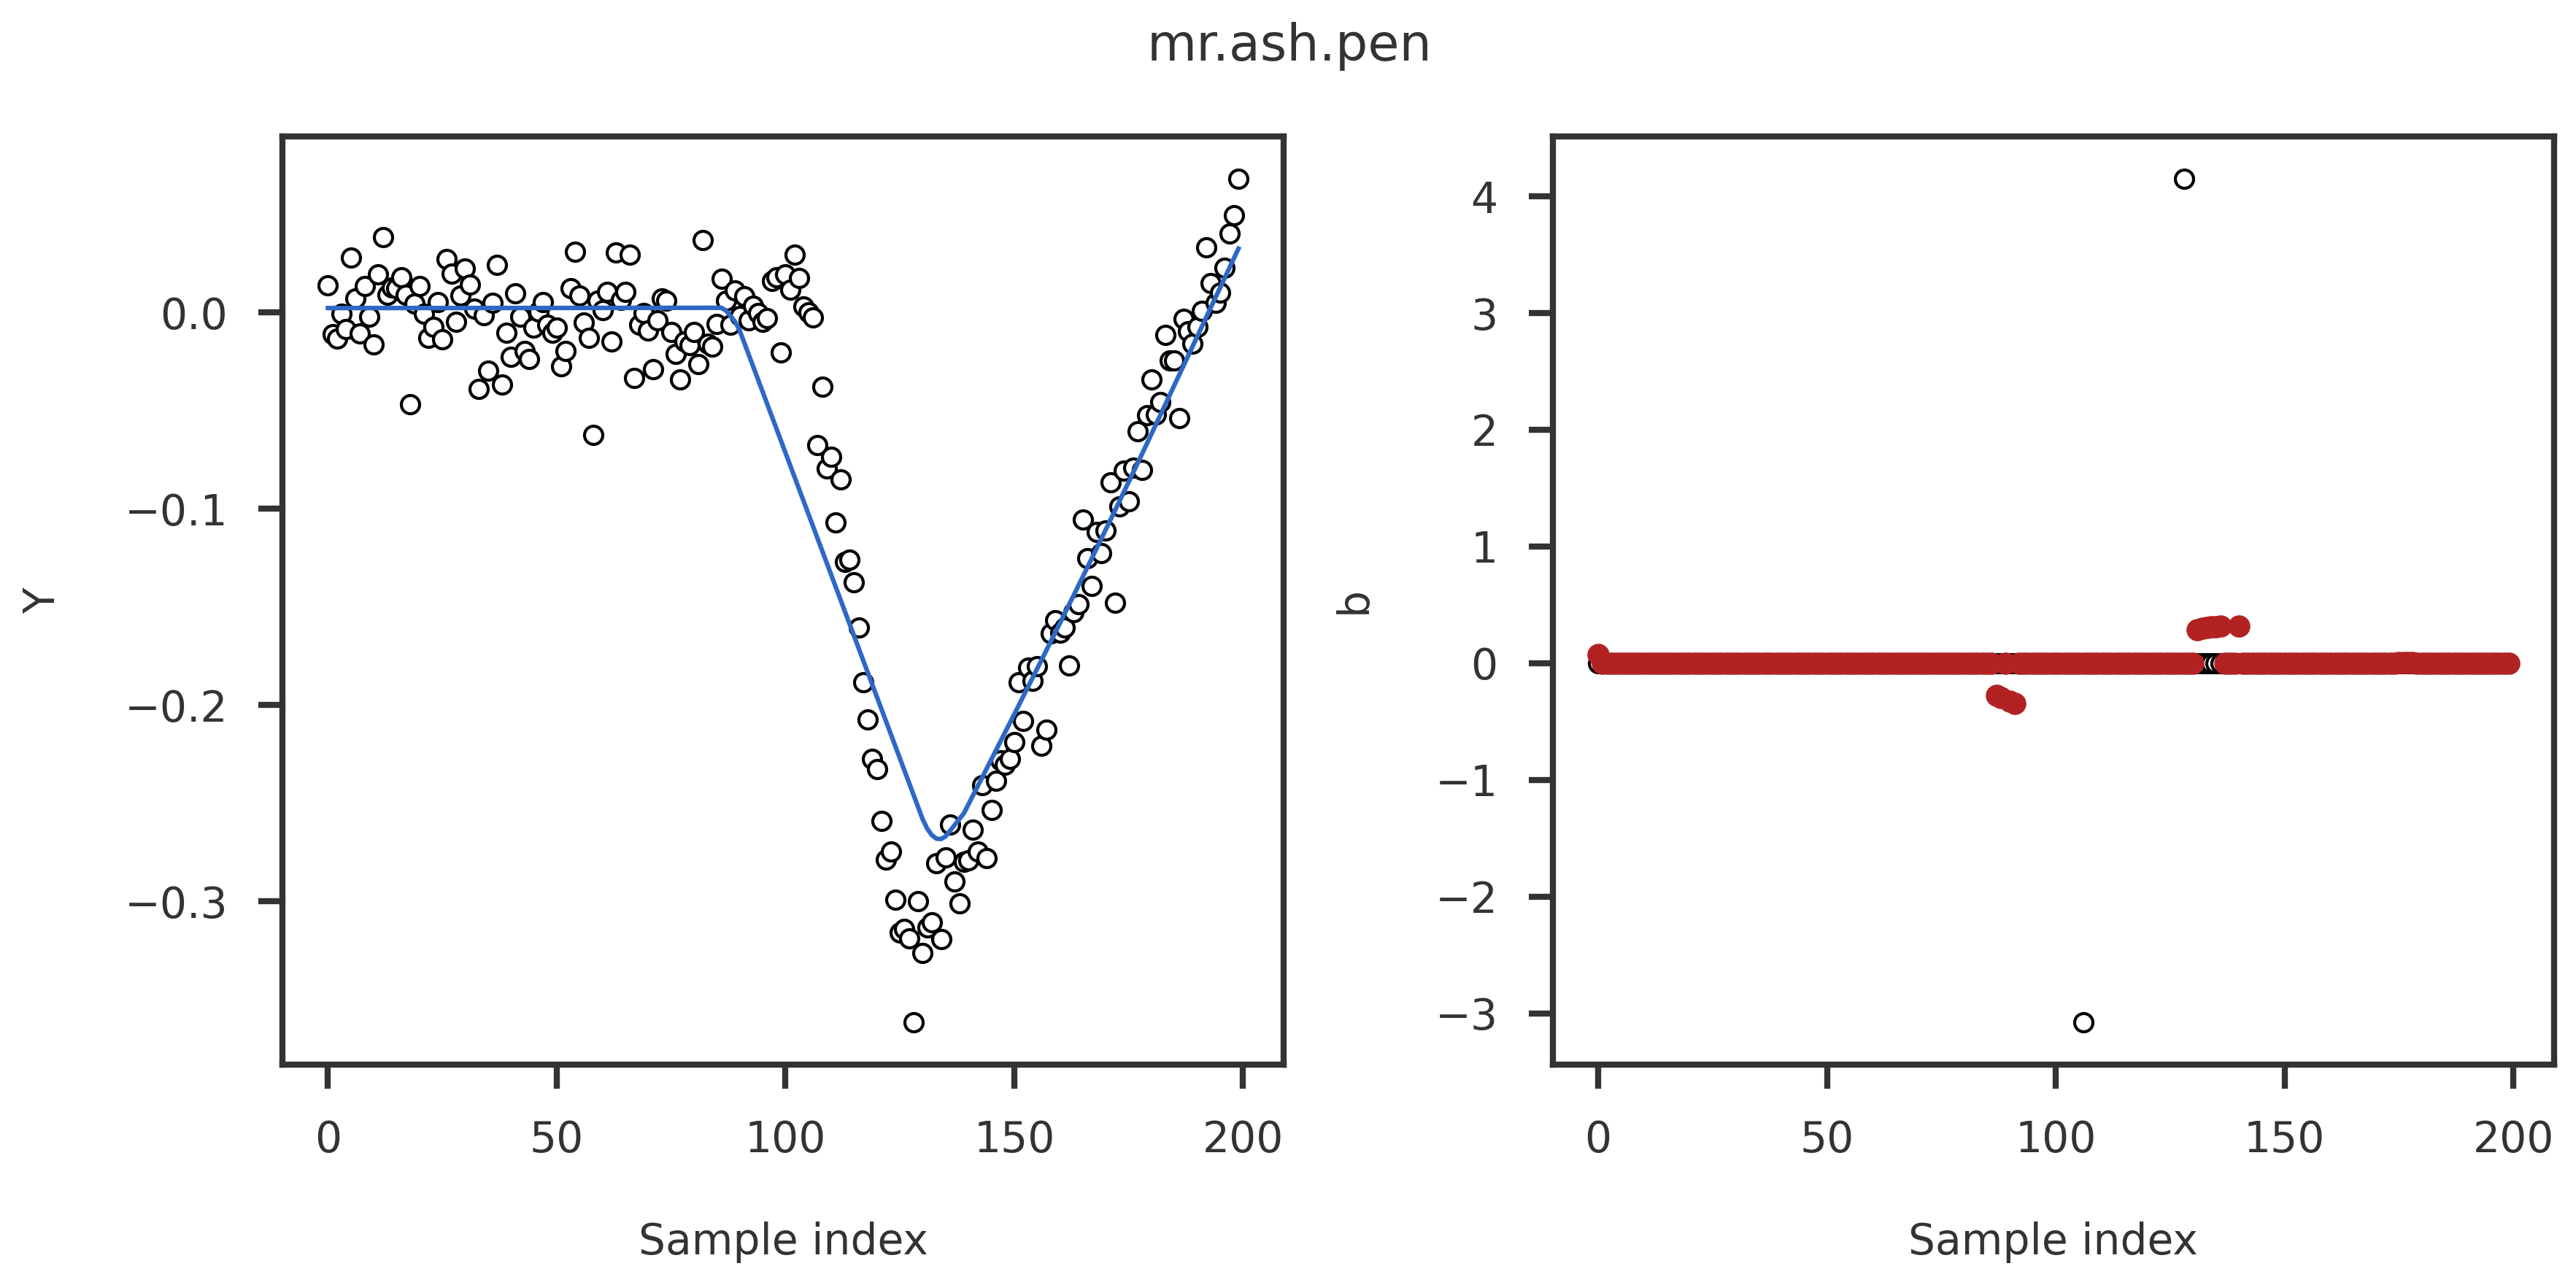

In [4]:
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')

In [5]:
import collections
RES_FIELDS = ['theta', 'coef', 'prior', 'residual_var', 'intercept', 'elbo_path', 'outer_elbo_path', 'obj_path', 'niter']
class ResInfo(collections.namedtuple('_ResInfo', RES_FIELDS)):
    __slots__ = ()

In [6]:
def ws_one_step(X, y, b, winit, s2init, sk, dj):
    n, p = X.shape
    ### calculate posterior
    r      = y - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2init), winit, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()

    ### Update w
    wnew   = np.sum(phijk, axis = 0) / p

    ### Update s2
    bbar   = np.sum(phijk * mujk, axis = 1)
    a1     = np.sum(dj * bbar * btilde)
    varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
    s2new  = (varobj + p * (1 - wnew[0]) * s2init) / (n + p * (1 - wnew[0]))
    
    ### Update ELBO
    elbo   = elbo_py.scalemix(X, y, sk, b, wnew, s2new,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    
    return bbar, wnew, s2new, elbo


def ebfit(X, y, sk, 
          binit = None, winit = None, s2init = None,
          maxiter = 500, qb_maxiter = 20,
          calculate_elbo = True,
          epstol = 1e-8,
          unshrink_method = 'heuristic',
          is_prior_scaled = True,
          display_progress = False,
          debug = False,
          plr_debug = False
         ):
    
    n, p = X.shape
    k    = sk.shape[0]
    intercept = np.mean(y)
    y    = y - intercept
    dj   = np.sum(np.square(X), axis = 0)

    niter = 0
    wk    = winit
    s2    = s2init
    #bbar  = binit
    elbo  = np.inf
    theta = np.zeros(p)
    elbo_path       = list()
    obj_path        = list()
    outer_elbo_path = list()
    
    plr = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False,
          debug = debug, 
          display_progress = display_progress, 
          calculate_elbo = calculate_elbo, 
          maxiter = qb_maxiter,
          unshrink_method = unshrink_method,
          prior_optim_method = 'softmax',
          call_from_em = True)
    
    
    for itr in range(maxiter):
        '''
        New coefficients
        '''
        #plr.fit(X, y, sk, binit = bbar, winit = wk, s2init = s2, inv_binit = theta)
        is_b_coef = True  if itr == 0 else False
        bold      = binit if itr == 0 else theta
        plr.fit(X, y, sk, binit = bold, winit = wk, s2init = s2, is_binit_coef = is_b_coef)
        theta      = plr.theta
        elbo_path += plr.elbo_path
        obj_path  += plr.obj_path
        '''
        Empirical Bayes update for wk and s2, also advances coef one step
        '''
        bbar, wk, s2, elbo = ws_one_step(X, y, plr.coef, plr.prior, plr.residual_var, sk, dj)
        outer_elbo_path.append(elbo)
        '''
        Termination criteria
        '''
        if (itr > 0) and (elboold - elbo < epstol): break
        elboold = elbo.copy()

        
    res = ResInfo(theta = theta,
                  coef = bbar,
                  prior = wk,
                  residual_var = s2,
                  intercept = intercept,
                  elbo_path = elbo_path,
                  outer_elbo_path = outer_elbo_path,
                  obj_path = obj_path,
                  niter = len(obj_path))

    return res

In [85]:
'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = wk, s2init = s2init, maxiter = 400, qb_maxiter = 100)

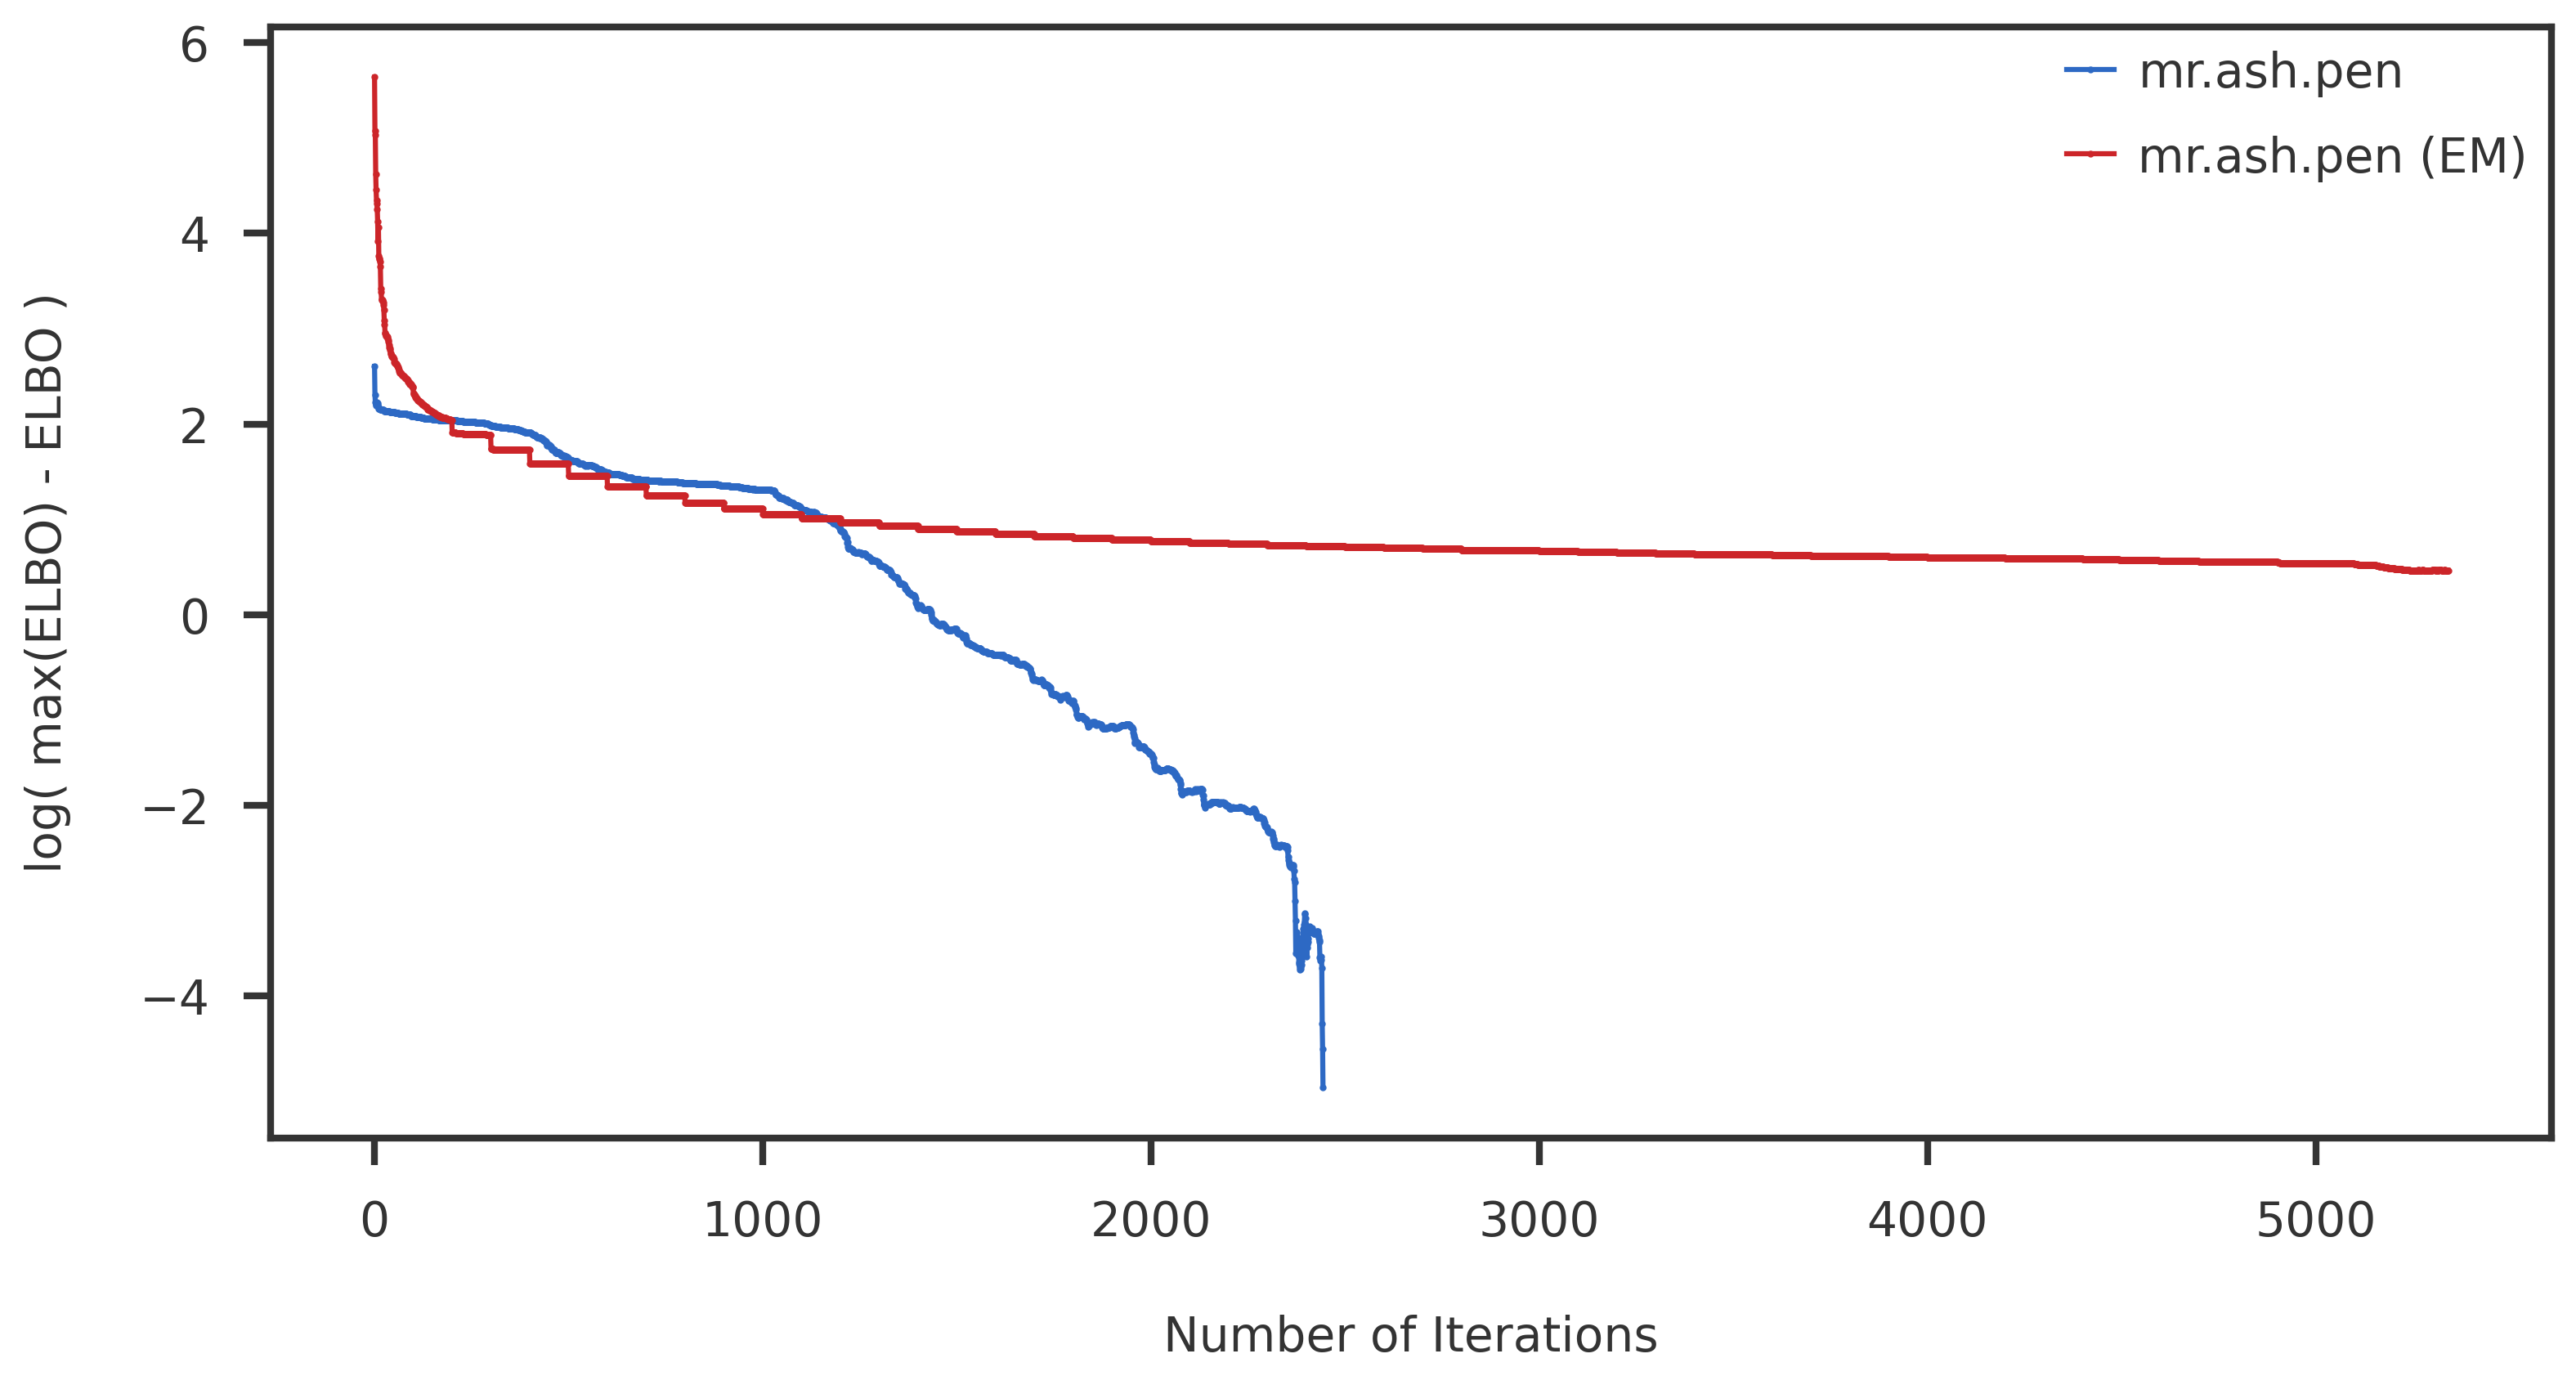

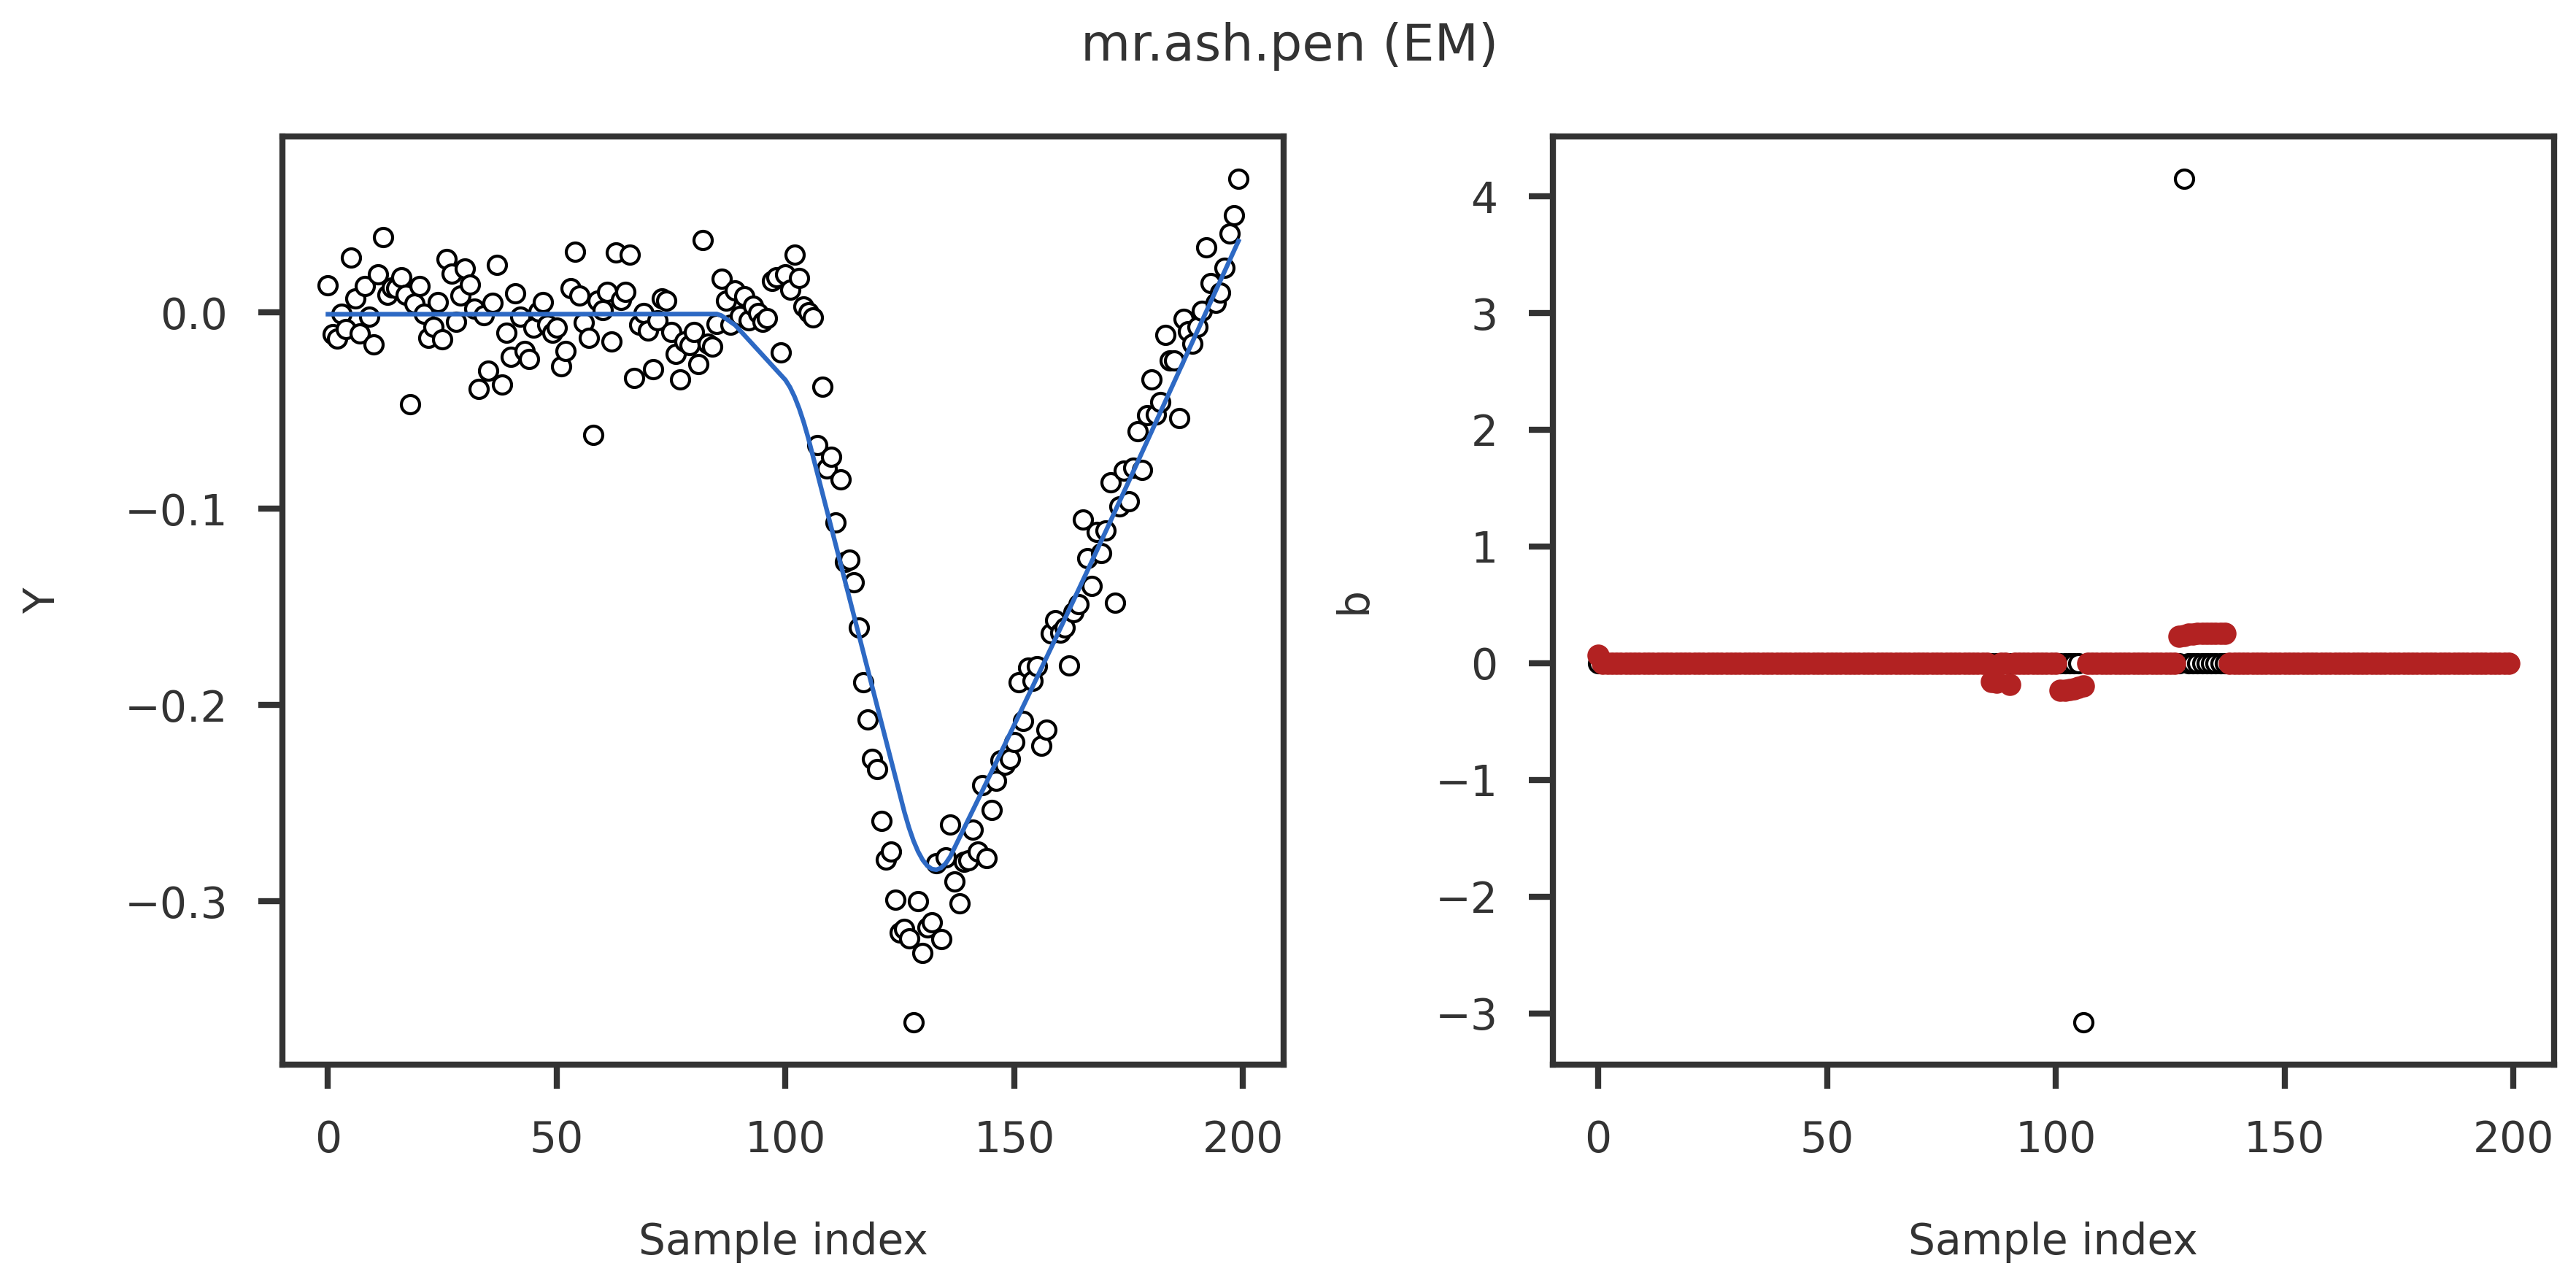

In [86]:
kinit   = [0, 0]
objs    = [plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')

In [71]:
qb_maxiter = 50
unshrink_method = 'heuristic'
yscale = y - np.mean(y)
dj = np.sum(np.square(X), axis = 0)
'''
Step 1
'''
plr1 = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False,
       debug = False, 
       display_progress = False, 
       calculate_elbo = True, 
       maxiter = qb_maxiter,
       unshrink_method = unshrink_method,
       prior_optim_method = 'softmax',
       call_from_em = True)
plr1.fit(X, yscale, sk, binit = lasso_b, winit = wk, s2init = s2init, inv_binit = np.zeros(p))
theta_1 = plr1.theta
bbar_1, wk_1, s2_1, elbo_1 = ws_one_step(X, yscale, plr1.coef, plr1.prior, plr1.residual_var, sk, dj)

In [72]:
elbo_1

760.3403945381206

In [15]:
plr_eb.outer_elbo_path

[760.3403945381206, 5427.632067877251]

In [83]:
qb_maxiter = 100
'''
Step 2
'''
plr2 = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False,
       debug = False, 
       display_progress = False, 
       calculate_elbo = True, 
       maxiter = qb_maxiter,
       unshrink_method = unshrink_method,
       prior_optim_method = 'softmax',
       call_from_em = True)
plr2.fit(X, yscale, sk, binit = theta_1, winit = wk_1, s2init = s2_1, is_binit_coef = False)
theta_2 = plr2.theta
bbar_2, wk_2, s2_2, elbo_2 = ws_one_step(X, yscale, plr2.coef, plr2.prior, plr2.residual_var, sk, dj)

In [80]:
elbo_2

11571.918896336718

In [84]:
elbo_py.scalemix(X, yscale, sk, plr2.coef, plr2.prior, plr2.residual_var)

-77.15601753994653

In [20]:
plr2.wparam_to_mixcoef(plr2._akinit)

array([0.02986577, 0.03009897, 0.03067147, 0.03112667, 0.03145001,
       0.03195943, 0.03275731, 0.03384688, 0.03536738, 0.0375692 ,
       0.04066875, 0.04473601, 0.04966761, 0.05524946, 0.06125988,
       0.06756868, 0.07424688, 0.0817352 , 0.09113231, 0.10902213])

In [25]:
elbo_py.scalemix(X, yscale, sk, plr1.coef, wk_1, s2_1)

968.9744705232266

In [26]:
def replicate_elbo(X, y, sk, b, winit, s2init, dj):
    n, p = X.shape
    ### calculate posterior
    r      = y - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2init), winit, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()

    ### Update w
    wnew   = np.sum(phijk, axis = 0) / p

    ### Update s2
    bbar   = np.sum(phijk * mujk, axis = 1)
    a1     = np.sum(dj * bbar * btilde)
    varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
    s2new  = (varobj + p * (1 - wnew[0]) * s2init) / (n + p * (1 - wnew[0]))

    ### Update ELBO
    elbo   = elbo_py.scalemix(X, y, sk, bbar, wnew, s2new,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo, phijk, mujk, varjk

In [27]:
_, phijk, mujk, varjk = replicate_elbo(X, yscale, sk, plr1.coef, plr1.prior, plr1.residual_var, dj)

In [28]:
elbo_py.scalemix(X, yscale, sk, bbar_1, wk_1, s2_1, 
                 dj = dj, phijk = phijk, mujk = mujk, varjk = varjk)

760.3403945381206

In [29]:
r_1 = yscale - np.dot(X, plr1.coef)
btilde  = plr1.coef + np.dot(X.T, r_1) / dj
nmash = NormalMeansASHScaled(btilde, np.sqrt(plr1.residual_var), plr1.prior, sk, d = dj, debug = False)
phijk_d, mujk_d, varjk_d = nmash.posterior()
elbo_py.scalemix(X, yscale, sk, plr1.coef, wk_1, s2_1, 
                 dj = dj, phijk = phijk_d, mujk = mujk_d, varjk = varjk_d)

760.3403945381206

In [30]:
r_2 = yscale - np.dot(X, plr2.coef)
btilde  = plr2.coef + np.dot(X.T, r_2) / dj
nmash = NormalMeansASHScaled(btilde, np.sqrt(plr2.residual_var), plr2.prior, sk, d = dj, debug = False)
phijk_d2, mujk_d2, varjk_d2 = nmash.posterior()
elbo_py.scalemix(X, yscale, sk, plr2.coef, wk_2, s2_2, 
                 dj = dj, phijk = phijk_d2, mujk = mujk_d2, varjk = varjk_d2)

5427.632067877251

In [32]:
_, phijk_2, mujk_2, varjk_2 = replicate_elbo(X, yscale, sk, plr2.coef, plr2.prior, plr2.residual_var, dj)

In [43]:
elbo_py.scalemix(X, yscale, sk, plr2.coef, wk_2, s2_2, 
                 dj = dj, phijk = phijk_d2, mujk = mujk_d2, varjk = varjk_d2)

5427.632067877251

In [55]:
elbo_debug, _, _, _ = replicate_elbo(X, yscale, sk, plr2.coef, plr2.prior, plr2.residual_var, dj)
print(elbo_debug)

5427.632067877251


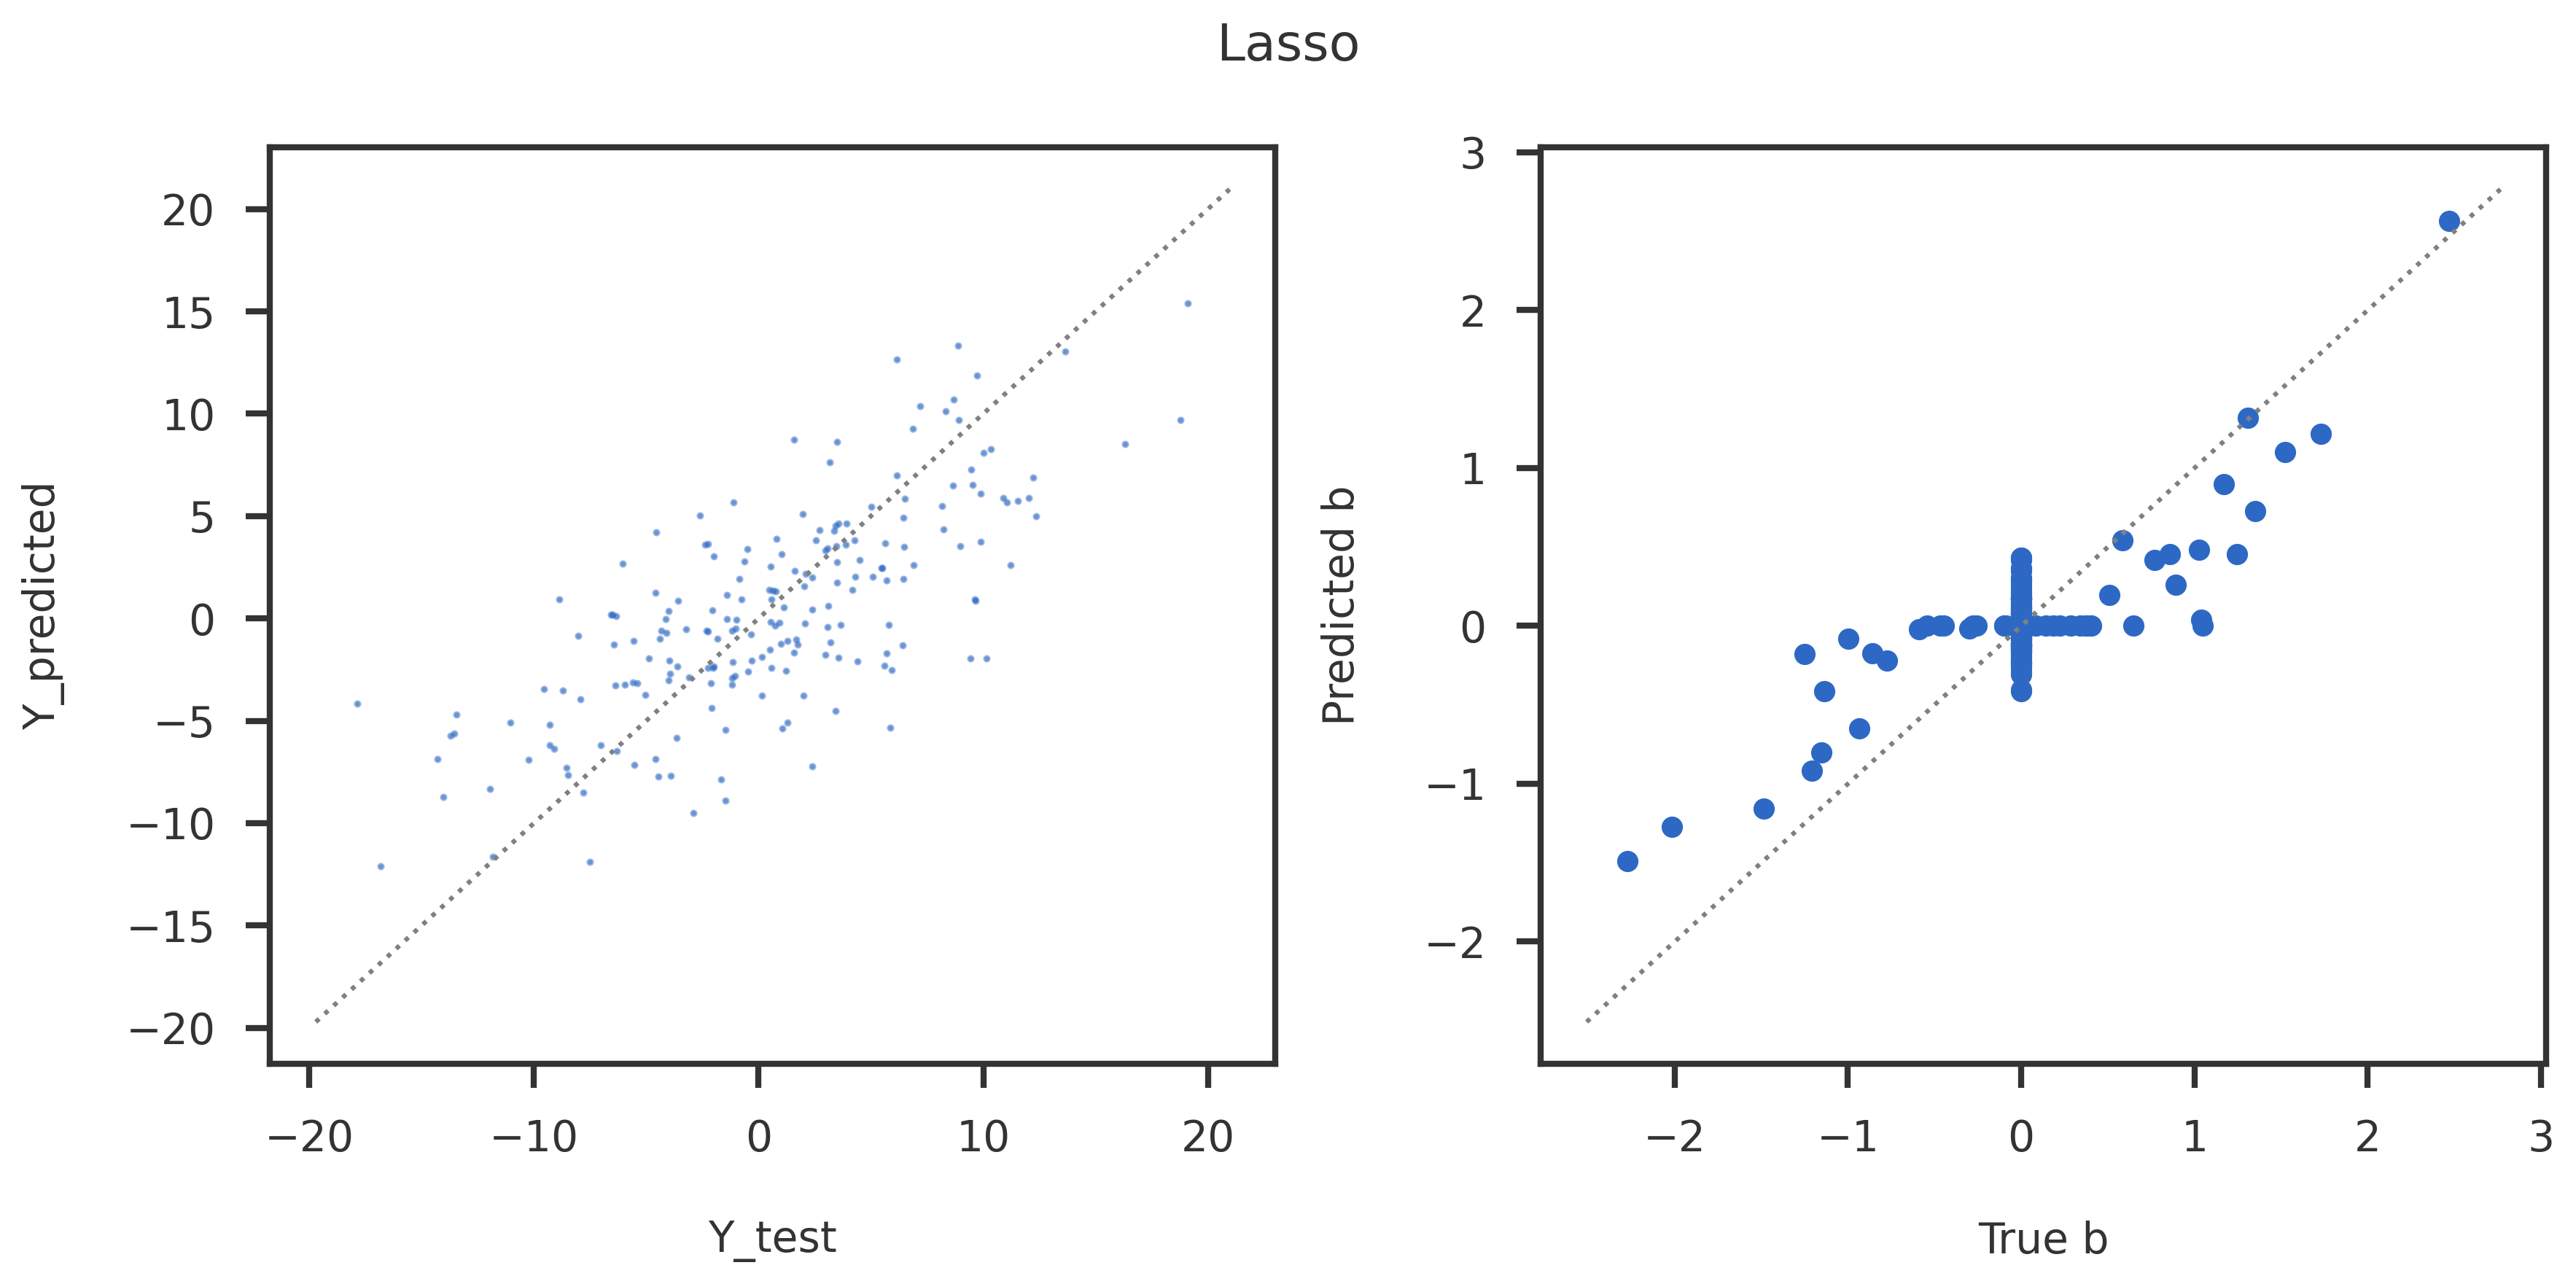

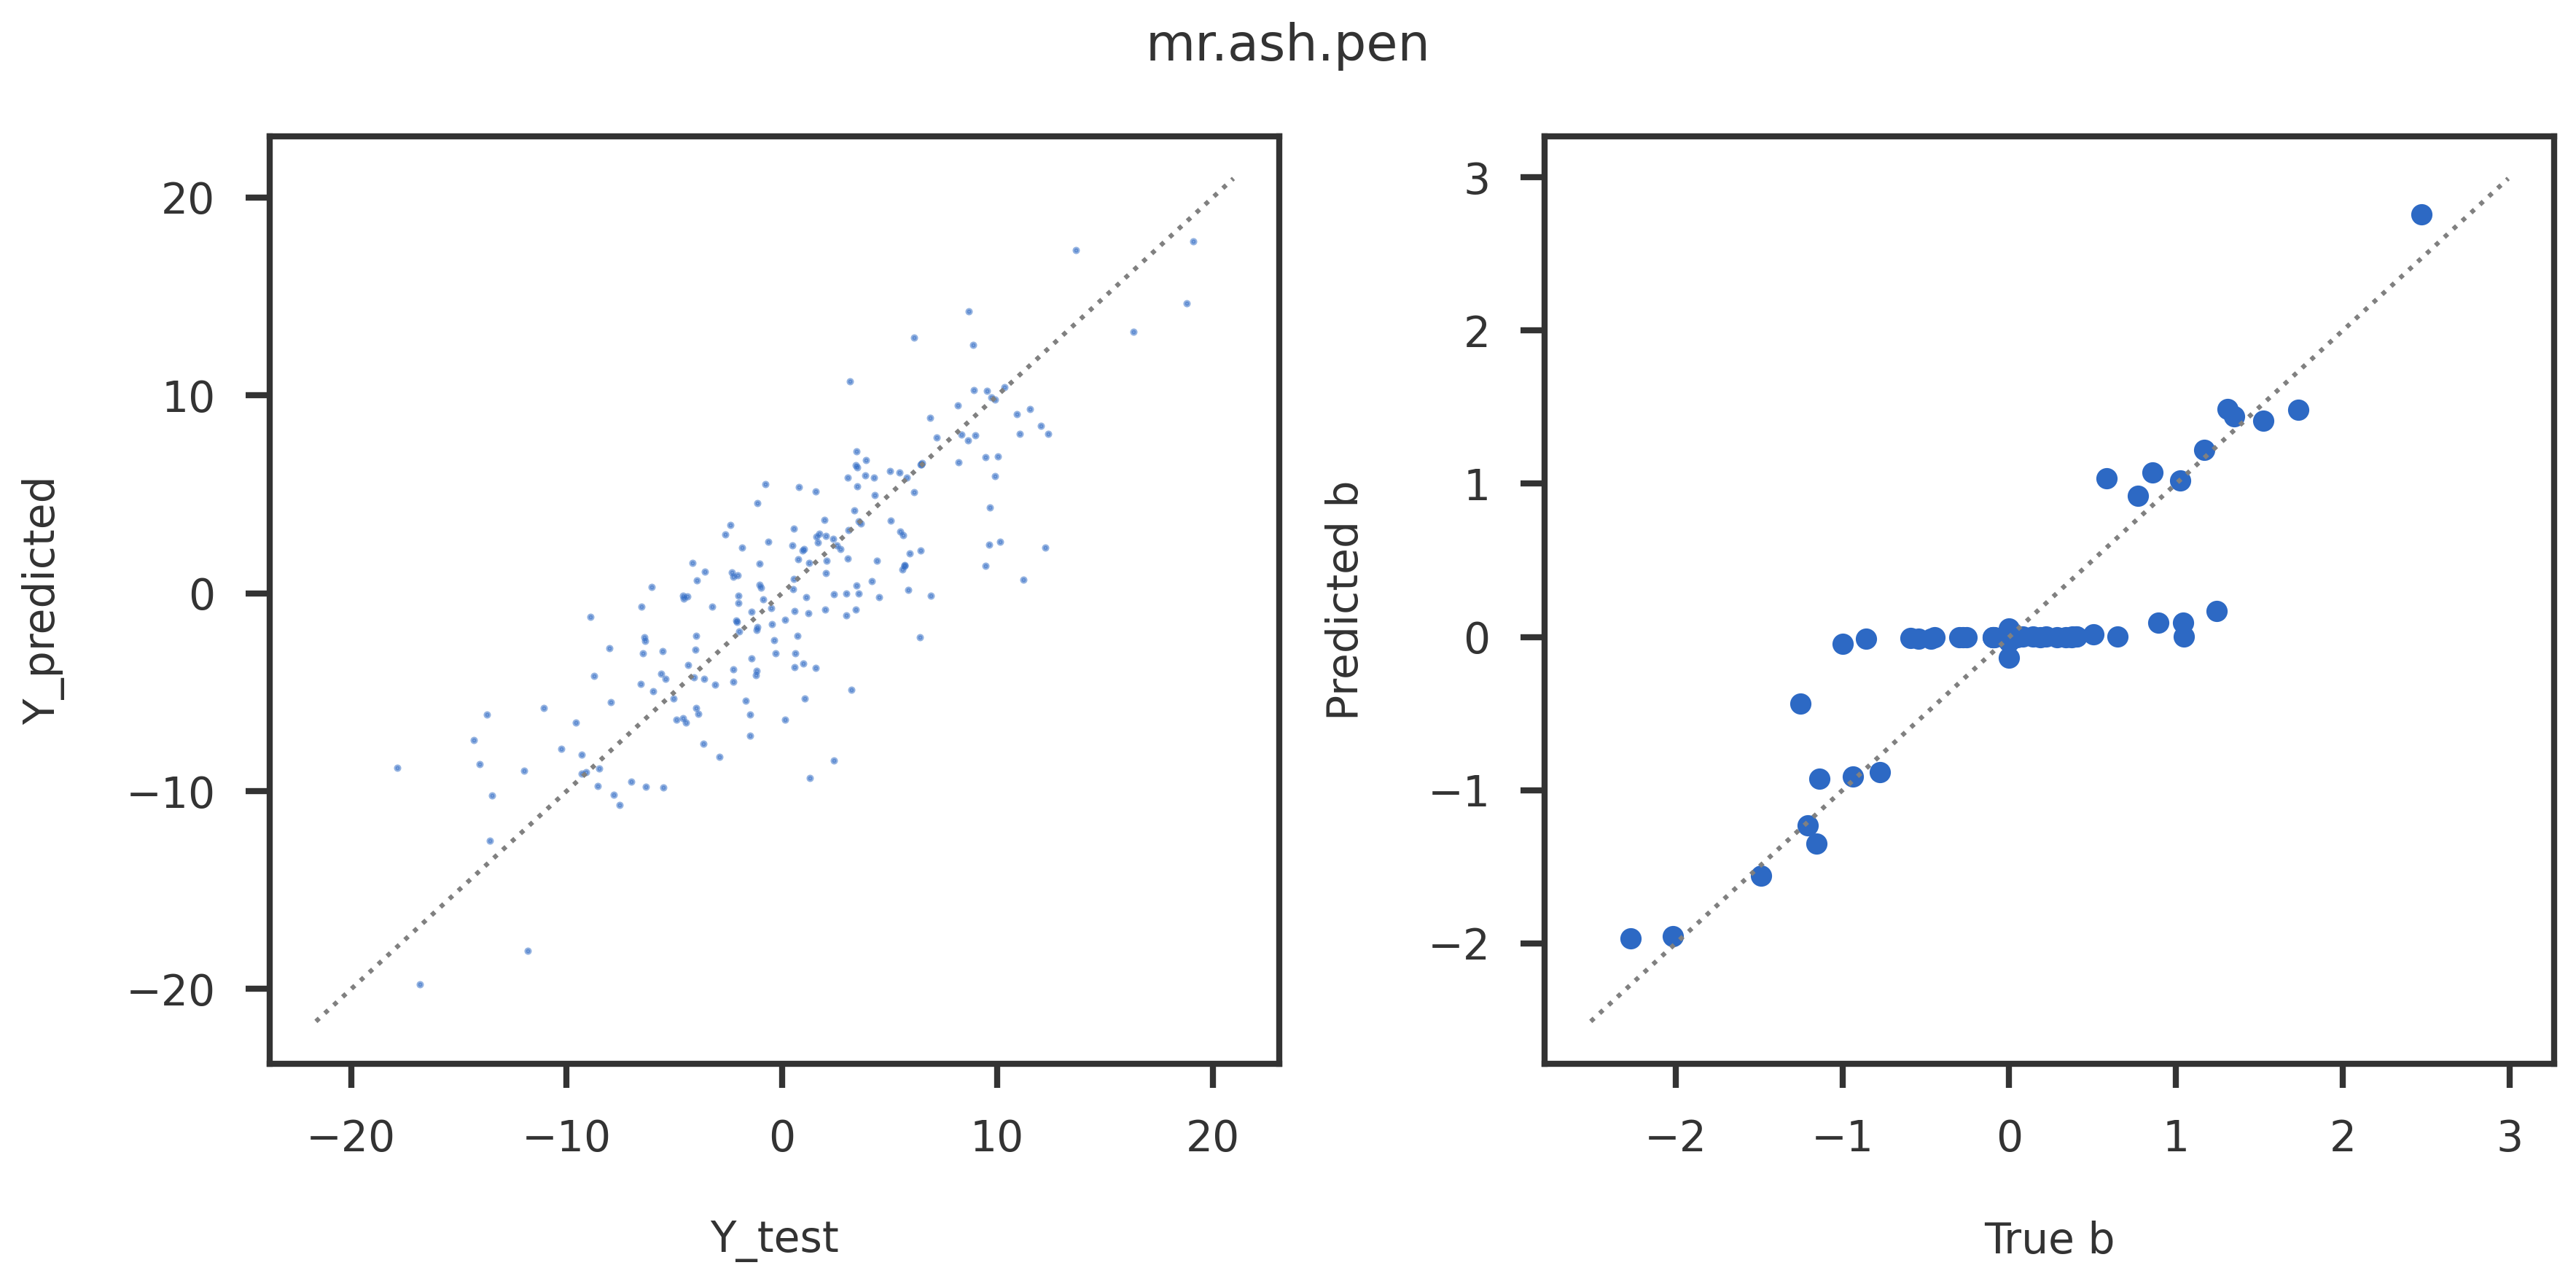

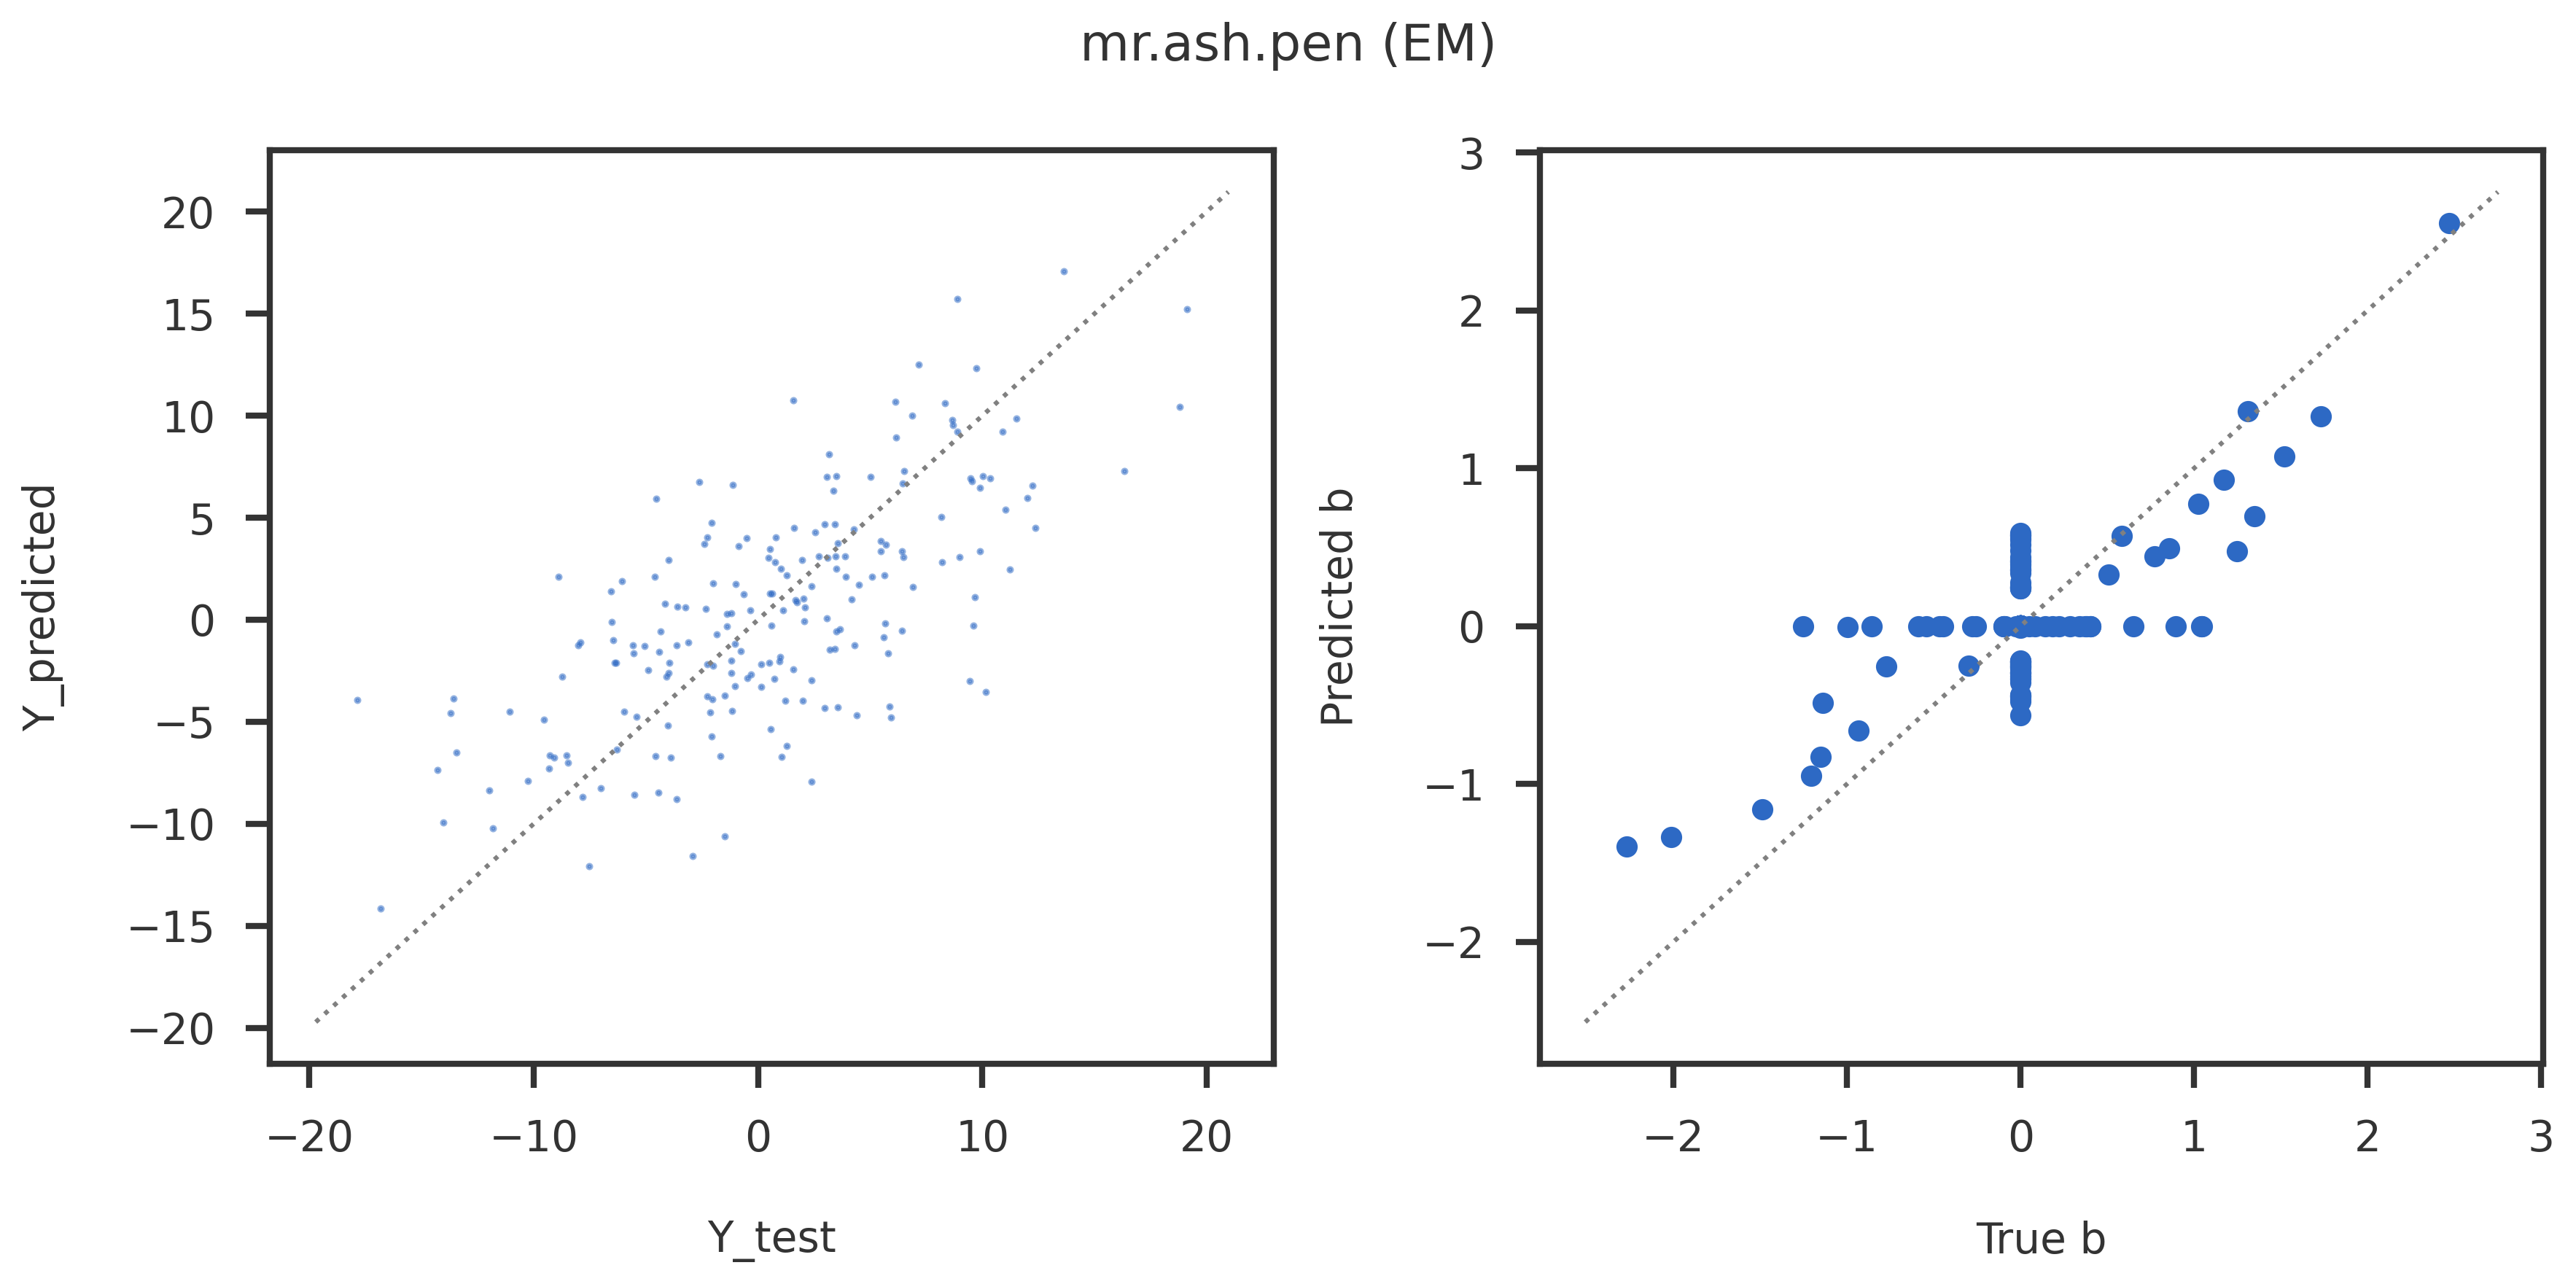

In [38]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                    plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')